# Lista prática I

**Instruções gerais:** Sua submissão deve conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynp

## Vizinhos mais próximos

**Exercício 1.** O código abaixo carrega o dataset MNIST, que consiste em imagens de dígitos entre $0$ e $9$. Teste o $k$-NN com distância euclidiana para classificação do conjunto de teste. Use valores de $k$ diferentes (e.g., de 1 a 5) e reporte a acurácia para cada valor de $k$. Lembre que a acurácia é o percentual de amostras classificadas corretamente. Notavelmente, as entradas do MNIST tem dimensão relativamente alta (64). Plote uma imagem com a variância amostral dos pixels das imagens e comente. Também mostre as imagens classificadas de maneira errônea e comente.

In [2]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import load_digits, make_moons
from sklearn.model_selection import train_test_split


SEED = 42
np.random.seed(SEED)

@dataclass
class Dataset:
    features_train: np.ndarray
    features_test: np.ndarray
    labels_train: np.ndarray
    labels_test: np.ndarray

# Import dataset and separate train/test subsets
mnist = Dataset(*train_test_split(
    *load_digits(return_X_y=True),
    random_state=SEED,
))

In [3]:
def knn_predict(X_test, X_train, y_train, k):
    """
    Perform k-nearest neighbors (KNN) prediction on a test set using a training set.

    Parameters
    ----------
    X_test : numpy.ndarray
        Test set features array with shape (n_samples, n_features).
    X_train : numpy.ndarray
        Training set features array with shape (n_samples, n_features).
    y_train : numpy.ndarray
        Training set target values with shape (n_samples,).
    k : int
        Number of nearest neighbors to consider in the KNN algorithm.

    Returns
    -------
    y_pred : numpy.ndarray
        Predicted target values for the test set using the KNN algorithm.
    """
    def predict_point(point):
        distances = np.sqrt(np.sum((X_train - point) ** 2, axis=1))  # Calculate Euclidean distances
        indices = np.argsort(distances)[:k]  # Get indices of k nearest neighbors
        labels = y_train[indices]  # Get labels of k nearest neighbors
        return np.bincount(labels).argmax()  # Return the most frequent label among the neighbors

    y_pred = [predict_point(X_test[n]) for n in range(len(X_test))]  # Make predictions for each data point
    return np.array(y_pred)

In [4]:
def calculate_acc_score(y_real, y_pred):
    """
    Calculate the accuracy score between true and predicted values.

    Parameters
    ----------
    y_real: numpy.ndarray
        True values.
    y_pred: numpy.ndarray
        Predicted values.

    Returns
    ----------
    accuracy: float
        Accuracy score.
    """
    correct_predictions = np.count_nonzero(y_real == y_pred)
    accuracy = correct_predictions / len(y_real)
    return accuracy

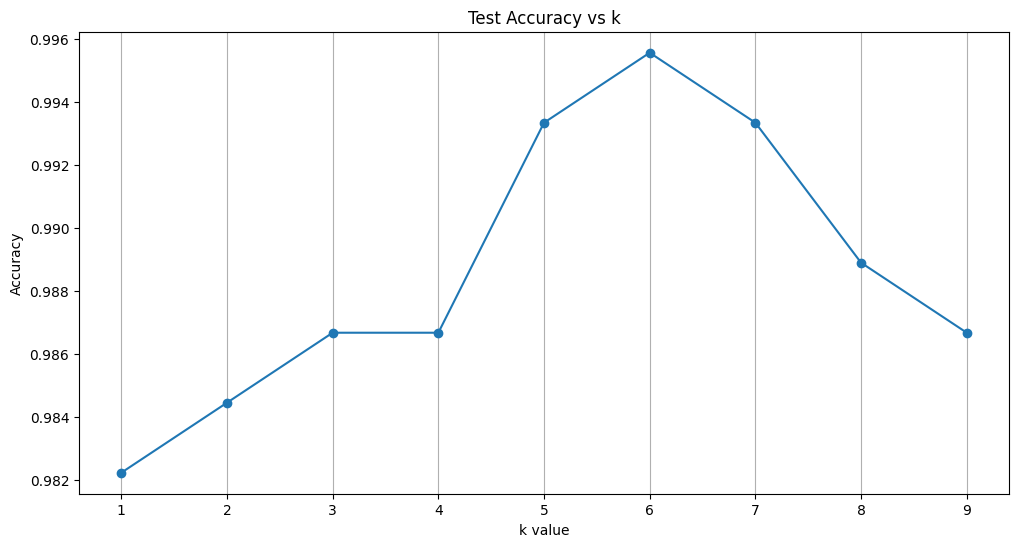

In [10]:
accuracies = []

# Valores de K a serem testados
K_values = list(range(1, 10))

# Treina e avalia o modelo para cada valor de K
for k in K_values:
    y_pred_test = knn_predict(mnist.features_test, mnist.features_train, mnist.labels_train, k)
    accuracy = calculate_acc_score(mnist.labels_test, y_pred_test)
    accuracies.append(accuracy)

# Plota a acurácia do conjunto de teste em relação aos valores de K
plt.figure(figsize=(12, 6))
plt.plot(K_values, accuracies, marker='o')
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs k')
plt.xticks(K_values)
plt.grid(True, axis='x')
plt.show()

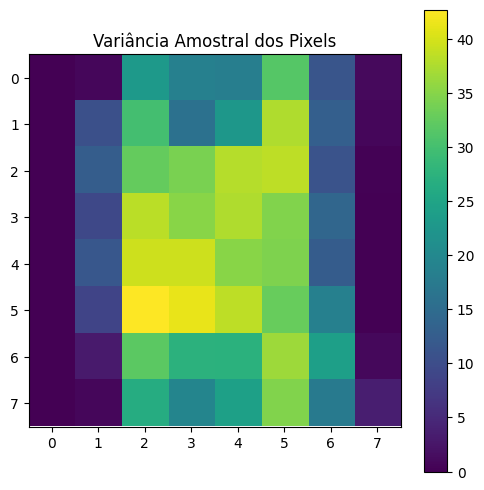

In [ ]:
# Plotar a variância amostral dos pixels das imagens
pixel_variance = np.var(mnist.features_train, axis=0).reshape(8, 8)
plt.figure(figsize=(6, 6))
plt.imshow(pixel_variance, cmap='viridis')
plt.colorbar()
plt.title('Variância Amostral dos Pixels')
plt.show()

Isso mostra que os pixels centrais variam mais que os pixels mais laterais, que em alguns casos parecem quase não variar. Isso faz sentido, já que os dígitos tendem a estar centralizados. 

Talvez, faça sentido testar usando apeans as regiões cuja variação é mais relevantes, fazendo com que pixeis mais laterais semjam desconsiderados.

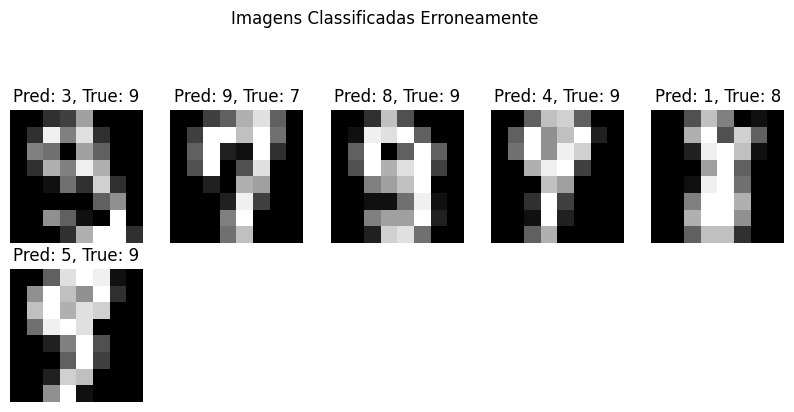

In [ ]:
# Mostrar imagens classificadas erroneamente
y_pred_test = knn_predict(mnist.features_test, mnist.features_train, mnist.labels_train, k=3)
incorrect_indices = np.where(y_pred_test != mnist.labels_test)[0]

plt.figure(figsize=(10, 10))
for i, idx in enumerate(incorrect_indices[:25]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(mnist.features_test[idx].reshape(8, 8), cmap='gray')
    plt.title(f'Pred: {y_pred_test[idx]}, True: {mnist.labels_test[idx]}')
    plt.axis('off')
plt.suptitle('Imagens Classificadas Erroneamente')
plt.show()

Aqui, podemos ver que as imagens classificadas erroneamente são difíceis até para um ser humano distinguir. Muitas delas poderiam ser consideradas como o valor predito, já que possuem uma deformação que as faz parecer com outros dígitos.

**Exercício 02.** O código abaixo carrega o dataset "two moons", que consiste de amostras bidimensionais divididas em duas classes. Teste o $k$-NN com distância euclidiana para classificação do conjunto de teste. Use valores de $k$ diferentes (e.g., de 1 a 10). Plote a superfície de decisão para cada valor de $k$. Como $k$ influencia na suavidade dessas superfícies?

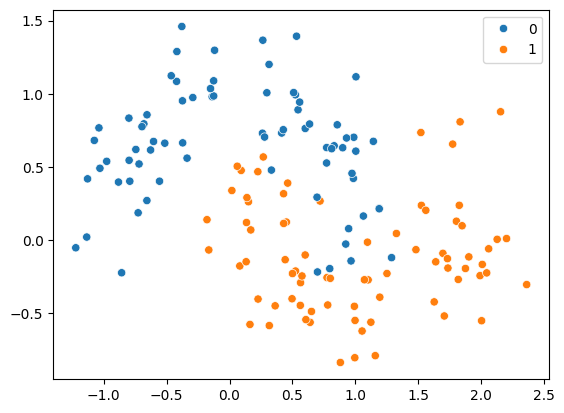

In [12]:
# Import dataset and separate train/test subsets
moon = Dataset(*train_test_split(
    *make_moons(n_samples=200, shuffle=True, noise=0.25, random_state=SEED),
    random_state=SEED,
))

# Let's also plot the moon dataset, for you to take a look at it.
sns.scatterplot(
    x=moon.features_train[:, 0],
    y=moon.features_train[:, 1],
    hue=moon.labels_train,
)
plt.show()

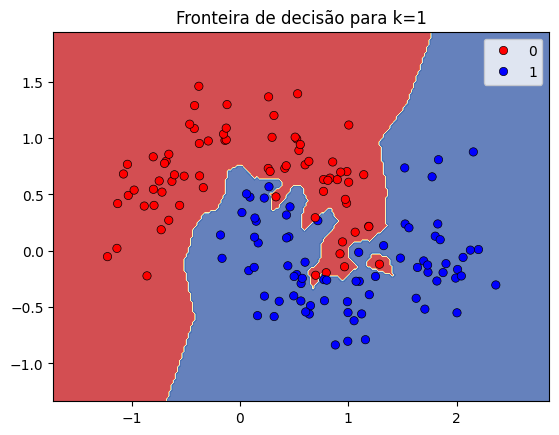

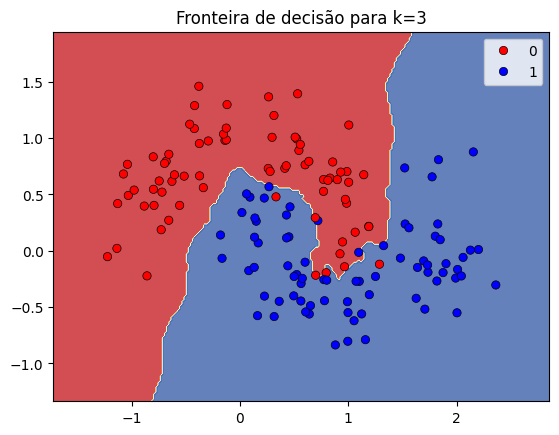

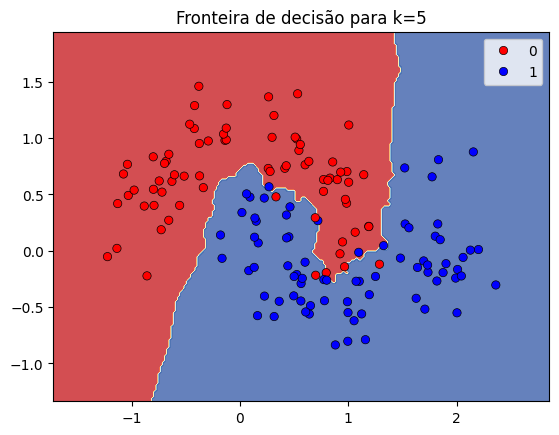

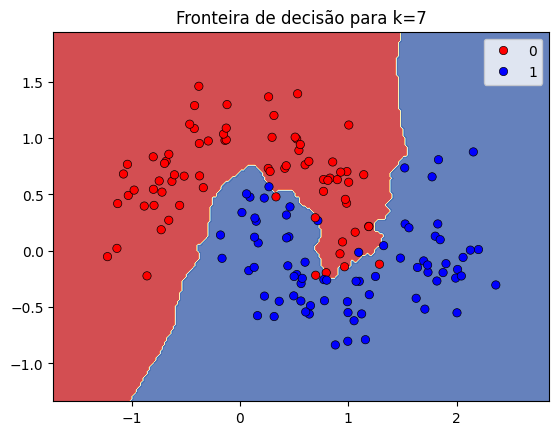

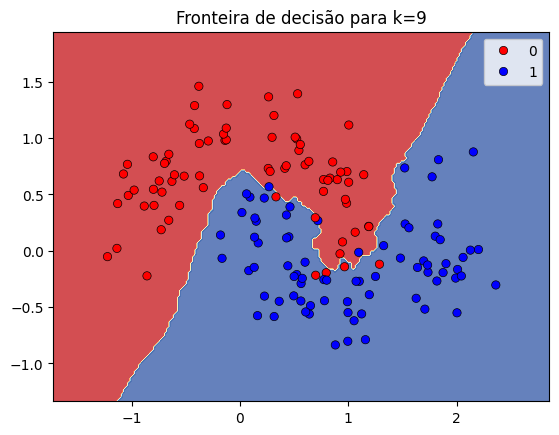

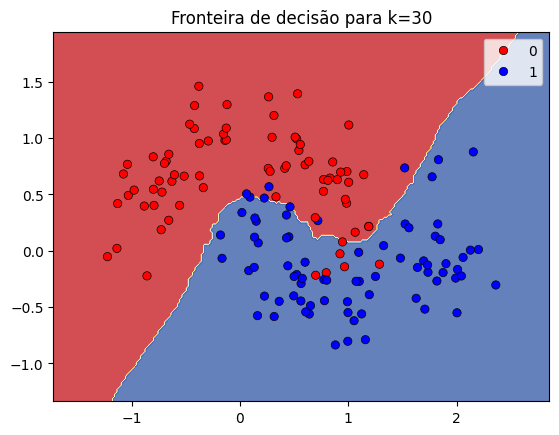

In [13]:
# Função para plotar a superfície de decisão
def plot_decision_boundary(X_train, y_train, k):
    """
    Plots the decision boundary for the KNN classifier.

    Parameters
    ----------
    X_train : numpy.ndarray
        Training set features array with shape (n_samples, n_features).
    y_train : numpy.ndarray
        Training set target values with shape (n_samples,).
    k : int
        Number of nearest neighbors to consider in the KNN algorithm.
    """
    # Define the grid for plotting
    x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
    y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    # Predict for each point in the grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = knn_predict(grid_points, X_train, y_train, k)
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    sns.scatterplot(
        x=X_train[:, 0],
        y=X_train[:, 1],
        hue=y_train,
        edgecolor='k',
        palette={0: 'red', 1: 'blue'},
    )
    plt.title(f"Fronteira de decisão para k={k}")
    plt.show()

# Testar diferentes valores de k e plotar as superfícies de decisão
K_values = list(range(1, 11, 2)) + [30]
for k in K_values:
    plot_decision_boundary(moon.features_train, moon.labels_train, k)

À medida que **k** aumenta, a superfície de decisão se torna mais suave, rou seja, há uma generalização melhor do modelo.

# Regressão linear

**Exercício 1.** Deixamos à sua disposição o dataset ["California Housing"](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing), dividio em treino, teste e validação.
O modelo que você utilizará para aproximar a relação funcional entre as features e as labels é o modelo linear, i.e., $\mathbf{y} = X\theta$.
Entretanto, você deve estimar seus parâmetros (minimizando o *mean squared error*) com **dois algoritmos diferentes**.
Uma implementação deve estimar $\theta$ por meio de **Stochastic Gradient Descent (SGD)** e, a outra, por meio de **Ordinary Least Squares (OLS)**, ou seja, utilizar a solução em fórmula fechada vista em aula.

Para o SGD, o ponto inicial deve ser escolhido aleatoriamente e o algoritmo deve parar quando a norma da diferença entre duas estimativas consecutivas de $\theta$ for menor do que um $\varepsilon > 0$ previamente especificado.
Para o experimento a seguir, fixe $\varepsilon$ em um valor pequeno (por exemplo, alguma potência de $1/10$) para a qual o algoritmo convirja no máximo em alguns minutos para uma solução com perda pequena.

Para diferentes tamanhos de minibatch (por exemplo $\{2^{j}: 1 \leq j \leq 7\}$), plote um gráfico representando o valor da perda $ L(\hat{\theta}) = \frac{1}{n} \lVert X \hat{\theta} - \mathbf{y} \rVert^{2}$ no conjunto de validação em função do número de epochs. Mostre também o valor ótimo obtido com OLS. Comente os resultados e o efeito tamanho do mini-batch, e.g., no tempo de treinamento. Reporte valores nos conjuntos de treino, validação e teste.

In [14]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

SEED = 42
np.random.seed(SEED)

features, labels = fetch_california_housing(return_X_y=True)

features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.25
)
features_train, features_validation, labels_train, labels_validation = train_test_split(
    features_train, labels_train, test_size=0.25
)

In [15]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Function for linear regression using OLS (closed-form solution)
def linear_regression_OLS(X, y):
    """
    Implements linear regression using the closed-form solution (OLS).

    Parameters:
    X : array
        Feature matrix (samples in rows, features in columns).
    y : array
        Labels vector.

    Returns:
    w : array
        Learned parameters (including bias).
    """
    X = X.copy()
    y = y.copy()

    X_bias = np.insert(X, obj=0, values=1, axis=1)  # Add bias column
    w = np.linalg.pinv(X_bias.T @ X_bias) @ X_bias.T @ y  # Closed-form solution
    return w

In [16]:
import time
import pandas as pd

# Treinar o modelo usando OLS
start_time = time.time()
w_ols = linear_regression_OLS(features_train, labels_train)
end_time = time.time()
ols_time = end_time - start_time

y_pred_train_ols = np.insert(features_train, 0, 1, axis=1) @ w_ols
y_pred_validation_ols = np.insert(features_validation, 0, 1, axis=1) @ w_ols
y_pred_test_ols = np.insert(features_test, 0, 1, axis=1) @ w_ols

mse_train_ols = mean_squared_error(labels_train, y_pred_train_ols)
mse_validation_ols = mean_squared_error(labels_validation, y_pred_validation_ols)
mse_test_ols = mean_squared_error(labels_test, y_pred_test_ols)

print(f"OLS - MSE Train: {mse_train_ols:.4f}, Validation: {mse_validation_ols:.4f}, Test: {mse_test_ols:.4f}")

OLS - MSE Train: 0.5158, Validation: 0.5356, Test: 0.5421


In [17]:
# Function for linear regression using SGD
def linear_regression_SGD(X, y, X_val, y_val, lr, max_iter, batch_size, epsilon):
    """
    Implements linear regression using Stochastic Gradient Descent (SGD).

    Parameters:
    X : array
        Feature matrix (samples in rows, features in columns).
    y : array
        Labels vector.
    lr : float
        Learning rate.
    max_iter : int
        Maximum number of epochs.
    batch_size : int
        Minibatch size.
    epsilon : float
        Stopping criterion (norm of the difference between weights).

    Returns:
    w : array
        Learned parameters (including bias).
    mse_history : list
        MSE history for each epoch.
    """
    X = X.copy()
    y = y.copy()
    mse_history = []

    # Normalization
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X = (X - X_mean) / X_std

    # Add a bias column to the input data X
    X_bias = np.insert(X, obj=0, values=1, axis=1)  # Add bias column
    n_samples = X_bias.shape[0]

    # Normalization of the validation set
    X_val = (X_val - X_mean) / X_std
    X_val = np.insert(X_val, 0, 1, axis=1)


    # Initialize the weights
    w = np.random.normal(scale=0.1, size=(X_bias.shape[1]))  # Initialize weights randomly

    # Loop for training the model using Stochastic Gradient Descent (SGD)
    for epoch in range(max_iter):
        indices = np.arange(n_samples)
        np.random.shuffle(indices)

        # Loop over the minibatches
        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            X_batch = X_bias[batch_indices]
            y_batch = y[batch_indices]

            # Calculate the gradient
            gradient = - (2 / batch_size) * X_batch.T.dot(y_batch - np.dot(X_batch, w))  # MSE gradient

            # Update the weights
            w_new = w - lr * gradient

            # Stop criteria
            if np.linalg.norm(w_new - w) < epsilon:
                return w_new, mse_history

            w = w_new

        # Calculate the MSE
        y_pred = np.dot(X_val, w)
        mse = mean_squared_error(y_val, y_pred)
        mse_history.append(mse)

    return w, mse_history

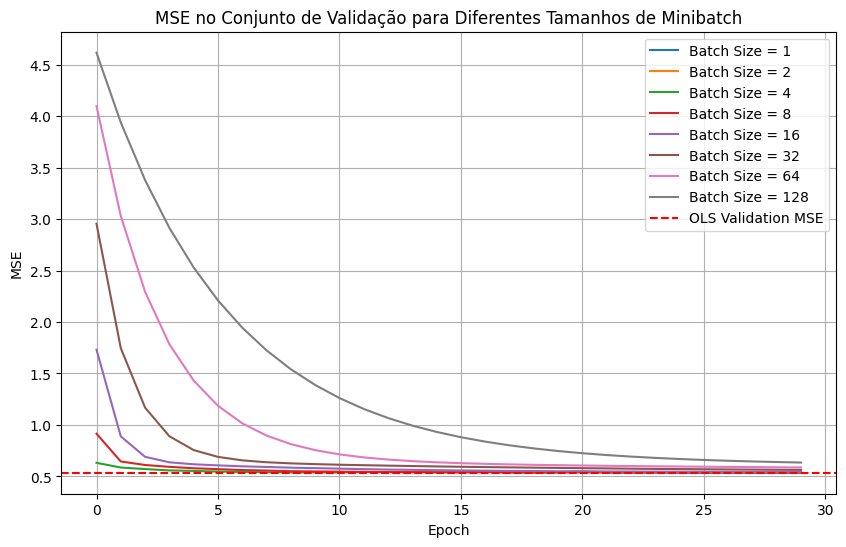

In [18]:
# Treinar o modelo usando SGD com diferentes tamanhos de minibatch
batch_sizes = [2**j for j in range(0, 8)]  # Tamanhos de minibatch
lr = 0.0005  # Taxa de aprendizado
epsilon = 1e-5  # Critério de parada
max_iter=30

plt.figure(figsize=(10, 6))
for batch_size in batch_sizes:
    w_sgd, mse_history = linear_regression_SGD(features_train, labels_train, features_validation, labels_validation, lr, max_iter, batch_size, epsilon)
    plt.plot(mse_history, label=f"Batch Size = {batch_size}")

plt.axhline(y=mse_validation_ols, color='r', linestyle='--', label="OLS Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE no Conjunto de Validação para Diferentes Tamanhos de Minibatch")
plt.legend()
plt.grid(True)
plt.show()

Podemos observar que, conforme aumentamos o tamanho do batch, a redução do erro ocorre de forma mais lenta. Isso era esperado, pois quanto maior o batch, menor o número de iterações internas em uma epoch e, consequentemente, menor o número de atualizações dos parâmetros.

In [20]:
# Função para calcular o tempo de execução e os resultados
def evaluate_sgd(X_train, y_train, X_val, y_val, X_test, y_test, lr, max_iter, batch_size, epsilon):
    start_time = time.time()
    w_sgd, _ = linear_regression_SGD(X_train, y_train, X_val, y_val, lr, max_iter, batch_size=batch_size, epsilon=epsilon)
    end_time = time.time()
    elapsed_time = end_time - start_time

    #Normalização
    norm_parm = np.mean(X_train, axis=0), np.std(X_train, axis=0)

    # Normaliza os dados
    X_train_bias = np.insert((X_train - norm_parm[0]) / norm_parm[1], 0, 1, axis=1)
    X_val_bias = np.insert((X_val - norm_parm[0]) / norm_parm[1], 0, 1, axis=1)
    X_test_bias = np.insert((X_test - norm_parm[0]) / norm_parm[1], 0, 1, axis=1)

    # Faz a predição
    y_pred_train_sgd = X_train_bias @ w_sgd
    y_pred_val_sgd = X_val_bias @ w_sgd
    y_pred_test_sgd = X_test_bias @ w_sgd

    # Calcula o MSE
    mse_train_sgd = mean_squared_error(y_train, y_pred_train_sgd)
    mse_val_sgd = mean_squared_error(y_val, y_pred_val_sgd)
    mse_test_sgd = mean_squared_error(y_test, y_pred_test_sgd)

    return mse_train_sgd, mse_val_sgd, mse_test_sgd, elapsed_time

results = [["OLS", mse_train_ols, mse_validation_ols, mse_test_ols, ols_time]]

for batch_size in batch_sizes:
    mse_train, mse_val, mse_test, elapsed_time = evaluate_sgd(
        features_train, labels_train, features_validation, labels_validation, features_test, labels_test, lr, max_iter, batch_size, epsilon)
    results.append([f"SGD - bs_{batch_size}", mse_train, mse_val, mse_test, elapsed_time])

In [21]:
# Exibir os resultados em forma de tabela
columns = ["Batch Size", "Train MSE", "Validation MSE", "Test MSE", "Time (s)"]
df= pd.DataFrame(results, columns=columns)

display(df)

,Batch Size,Train MSE,Validation MSE,Test MSE,Time (s)
0,OLS,0.515847,0.535625,0.542085,0.006101
1,SGD - bs_1,2.007493,2.036591,1.988571,0.009133
2,SGD - bs_2,0.575713,0.580110,0.560959,0.063718
3,SGD - bs_4,0.516216,0.535710,0.547024,0.663469
4,SGD - bs_8,0.516354,0.536488,0.543537,0.320513
5,SGD - bs_16,0.522125,0.544042,0.542235,0.162798
6,SGD - bs_32,0.538640,0.557673,0.548081,0.091423
7,SGD - bs_64,0.568460,0.585261,0.571345,0.051139
8,SGD - bs_128,0.638040,0.650965,0.638095,0.033985


Aqui, podemos ver que o aumento do tamanho do batch, até certo ponto, faz com que a aproximação seja maior ao valor mínimo real (OLS). Podemos ver que com o batch de tamanho 1, não conseguimos nos aproximar adequadamente do valor mínimo, enquanto que com o batch de tamanho 4 chegamos muito próximo. Ao aumentar o batch, contudo, começamos a perceber uma degradação na performance.

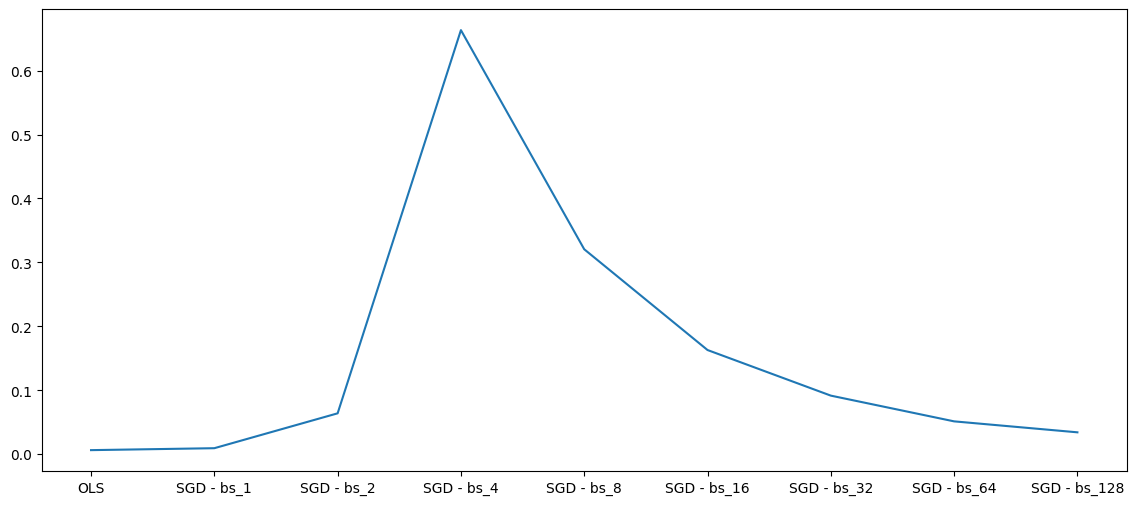

In [33]:
plt.figure(figsize=(14, 6))
plt.plot(df["Batch Size"], df["Time (s)"])


Em relação ao tempo, novamente, vemos que o OLS é o mais rápido (esperado), já que se trata da forma fechada. Em seguida, temos o gradiente estocástico linha a linha, já que aqui fazemos contas em forma não matricial. Por fim, vemos um aumento no tempo de processamento até um ponto onde ele volta a diminuir.

Isso ocorre porque, apesar de aumentar o tamanho da matriz, diminuímos muito o número de contas necessárias com matrizes maiores, chegando a um ponto no qual o tempo compensa e começa a diminuir.

Aqui, não usamos GPU.

**Exercício 2.** Agora, você deve implementar uma **Rede RBF** com função de base Gaussiana (veja as notas de aula).
Para os centróides, utilize o output de um modelo de clusterização por K médias, por meio da função que disponibilizamos, como a seguir:

In [ ]:
def k_means_factory(n_clusters: int) -> KMeans:
    return KMeans(n_clusters=n_clusters, n_init="auto")

k_means_model = k_means_factory(n_clusters=2)
dumb_data = np.array(
    [[1, 2],
     [1, 4],
     [1, 0],
     [10, 2],
     [10, 4],
     [10, 0]]
)
k_means_model.fit(dumb_data)
cluster_centers = k_means_model.cluster_centers_
print(cluster_centers) # Shape (n_clusters, n_features)

Para determinar o melhor valor de $k$ para o algoritmo de clusterização, treine o modelo (usando a fórmula de OLS) com diferentes valores e escolha o que possuir o menor erro de validação. Faça um gráfico mostrando o valor do erro de validação para diferentes valores de $k$. Mostre também a performance do modelo escolhido no conjunto de teste. Compare com o modelo linear simples da questão anterior. Discuta os resultados.

Para definir o valor do hiper-parâmetro $\gamma$, use a seguinte heurística --- que pode ser achado no livro "Neural Networks", por Simon Haykin:

$$
\gamma = \frac{1}{d_\text{max}^2},
$$

onde $d_\text{max}$ é a maior distância entre um par de centróides. Note que o valor costuma mudar para $k$'s diferentes.


## Regressão logística

O pedaço de código abaixo carrega o banco de dados 'breast cancer' e adiciona uma coluna de bias. Além disse, ele o particiona em treino e teste.

1. Implemente a estimativa de máximo a posteriori para um modelo de regressão logística com priori $\mathcal{N}(0, c I)$ com $c=100$ usando esse banco de dados;
2. Implemente a aproximação de Laplace para o mesmo modelo;
3. Implemente uma aproximação variacional usando uma Gaussiana diagonal e o truque da reparametrização;
4. Calcule a accuracy no teste para todas as opções acima --- no caso das 2 últimas, a prob predita é $\int_\theta p(y|x, \theta) q(\theta)$;
5. Para cada uma das 3 técnicas, plote um gráfico com a distribuição das entropias para as predições corretas e erradas (separadamente), use a função kdeplot da biblioteca seaborn.
6. Comente os resultados, incluindo uma comparação dos gráficos das entropias.

Explique sua implementação também! 

Para (potencialmente) facilitar sua vida: use PyTorch, Adam como otimizador (é uma variação SGD) com lr=0.001, use o banco de treino inteiro ao invés de minibatchces, use binary_cross_entropy_with_logits para implementar a -log verossimilhança, use torch.autograd.functional para calcular a Hessiana. Você pode usar as bibliotecas importadas na primeira célula a vontade. Verifique a documentação de binary_cross_entropy_with_logits para garantir que a sua priori está implementada corretamente, preservando as proporções devidas. Use 10000 amostras das aproximações para calcular suas predições.

In [ ]:
data =  load_breast_cancer()
N = len(data.data)
Ntrain = int(np.ceil(N*0.6))
perm = np.random.permutation(len(data.data))
X = torch.tensor(data.data).float()
X = torch.cat((X, torch.ones((X.shape[0], 1))), axis=1)
y = torch.tensor(data.target).float()

Xtrain, ytrain = X[perm[:Ntrain]], y[perm[:Ntrain]]
Xtest, ytest = X[perm[Ntrain:]], y[perm[Ntrain:]]